## Model Training

In this section we will train three models and save them.

In [16]:
# Imports necessary libraries
import pickle
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc

In [2]:
# Opens the saved processed ranked game data
with open('data\\final_data.pkl', 'rb') as file:
    final_data = pickle.load(file)

match_features = list(final_data.columns[:-1])
match_stats = final_data[match_features].values

winning_team = list(final_data.columns[-1:])
win = final_data[winning_team].values

X = np.array(match_stats)
y = np.array(win)

We will start by training a simple neural network, and we will save the best neural network model by using the `callbacks` parameter.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 80% for training, 20% for testing

nn_model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                672       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,249
Trainable params: 1,249
Non-trainable params: 0
_________________________________________________________________


In [4]:
# Train and save the best model
callback = ModelCheckpoint(
    filepath='model\\win_prediction_nn_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    mode='max',
    verbose=1
)

nn_model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test), callbacks=[callback])
nn_accuracy = nn_model.evaluate(X_test, y_test)[1]
print(f'Neural Network Model Accuracy:{nn_accuracy: %}')

Epoch 1/20
104/104 [==============================] - 10s 7ms/step - loss: 0.5340 - accuracy: 0.8073 - val_loss: 0.3263 - val_accuracy: 0.9044

Epoch 00001: val_accuracy improved from -inf to 0.90442, saving model to model\win_prediction_nn_model.h5
Epoch 2/20
104/104 [==============================] - 0s 5ms/step - loss: 0.2580 - accuracy: 0.9098 - val_loss: 0.1941 - val_accuracy: 0.9328

Epoch 00002: val_accuracy improved from 0.90442 to 0.93285, saving model to model\win_prediction_nn_model.h5
Epoch 3/20
104/104 [==============================] - 0s 5ms/step - loss: 0.1748 - accuracy: 0.9354 - val_loss: 0.1454 - val_accuracy: 0.9462

Epoch 00003: val_accuracy improved from 0.93285 to 0.94616, saving model to model\win_prediction_nn_model.h5
Epoch 4/20
104/104 [==============================] - 0s 5ms/step - loss: 0.1348 - accuracy: 0.9487 - val_loss: 0.1195 - val_accuracy: 0.9504

Epoch 00004: val_accuracy improved from 0.94616 to 0.95039, saving model to model\win_prediction_nn_mod

Now, let's move on to the random forest model.

In [5]:
# Create and fit the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train.ravel())

rf_pred = rf_model.predict(X_test)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test.ravel(), rf_pred)

print(f'Random Forest Model Accuracy:{rf_accuracy: %}')

Random Forest Model Accuracy: 95.946763%


We will tune the hyperparameters using `GridSearchCV`. This process will take some time.

In [6]:
# Random Forest hyperparameter tuning
tuned_rf_model = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 150, 200],      # Number of trees in the forest
    'max_depth': [None, 1, 3, 5],         # Maximum depth of the trees
    'min_samples_split': [2, 3, 5, 7],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]         # Minimum number of samples required to be at a leaf node
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=tuned_rf_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train.ravel())

best_params = grid_search.best_params_

# Train the Random Forest model with the tuned hyperparameters
tuned_rf_model = RandomForestClassifier(random_state=42, **best_params)
tuned_rf_model.fit(X_train, y_train.ravel())

tuned_rf_pred = tuned_rf_model.predict(X_test)

# Calculate accuracy
tuned_rf_accuracy = accuracy_score(y_test.ravel(), tuned_rf_pred)

print(f'Tuned Random Forest Model Accuracy:{tuned_rf_accuracy: %}')

# Save the model using pickle
filename = f"model\\win_prediction_rf_model.bin"

with open(filename, "wb") as f:
    pickle.dump(tuned_rf_model, f)

Tuned Random Forest Model Accuracy: 95.886267%


We will train our last model with XGBoost.

In [7]:
# Create and fit the XGBoost model
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

# Calculate accuracy
xgb_accuracy = accuracy_score(y_test, xgb_pred)

print(f'XGBoost Model Accuracy:{xgb_accuracy: %}')

XGBoost Model Accuracy: 96.128252%


Similarly, we will tune the hyperparameters. This also will take some time.

In [8]:
# XGBoost hyperparameter tuning
tuned_xgb_model = XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [None, 1, 3, 5],
    'booster': ['gbtree'],
    'learning_rate': [0.05, 0.1, 0.2, 0.3],
    'objective': ['binary:logistic'],
    'eval_metric' : ['error'],
    'tree_method': ['gpu_hist']
}

# Perform Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=tuned_xgb_model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

# Train the XGBoost model with the tuned hyperparameters
tuned_xgb_model = XGBClassifier(random_state=42, **best_params)
tuned_xgb_model.fit(X_train, y_train)

tuned_xgb_pred = tuned_xgb_model.predict(X_test)

# Calculate accuracy
tuned_xgb_accuracy = accuracy_score(y_test.ravel(), tuned_xgb_pred)

print(f'Tuned XGBoost Model Accuracy:{tuned_xgb_accuracy: %}')

# Save the model using pickle
filename = f"model\\win_prediction_xgb_model.bin"

with open(filename, "wb") as f:
    pickle.dump(tuned_xgb_model, f)

Tuned XGBoost Model Accuracy: 96.733212%


***
## Model Evaluations

All three models have good accuracy, and in this section, we will evaluate the random forest and XGBoost models with tuned hyperparameters and analyze which match features are the most influential to winning the ranked match.

In [9]:
# Random Forest evaluation
rf_precision = precision_score(y_test, tuned_rf_pred, average='binary')
rf_recall = recall_score(y_test, tuned_rf_pred, average='binary')
rf_conf_matrix = confusion_matrix(y_test, tuned_rf_pred)

print(f'Precision: {rf_precision: %}')
print(f'Recall: {rf_recall: %}')
print(f'Confusion Matrix: \n {rf_conf_matrix}')

Precision:  94.655582%
Recall:  97.195122%
Confusion Matrix: 
 [[788  45]
 [ 23 797]]


In [10]:
# XGBoost evaluation
xgb_precision = precision_score(y_test, tuned_xgb_pred, average='binary')
xgb_recall = recall_score(y_test, tuned_xgb_pred, average='binary')
xgb_conf_matrix = confusion_matrix(y_test, tuned_xgb_pred)

print(f'Precision: {xgb_precision: %}')
print(f'Recall: {xgb_recall: %}')
print(f'Confusion Matrix: \n {xgb_conf_matrix}')

Precision:  96.033654%
Recall:  97.439024%
Confusion Matrix: 
 [[800  33]
 [ 21 799]]


Looks like precision and recall scores for the models are high. As a result, we observe low number of false negatives and false positives from the confusion matrices. In general, the models achieve high accruacy, precision, and recall. However, it seems that the XGBoost model does little better than the other two. Now, we will analyze the feature importance in blue team without loss of generality.

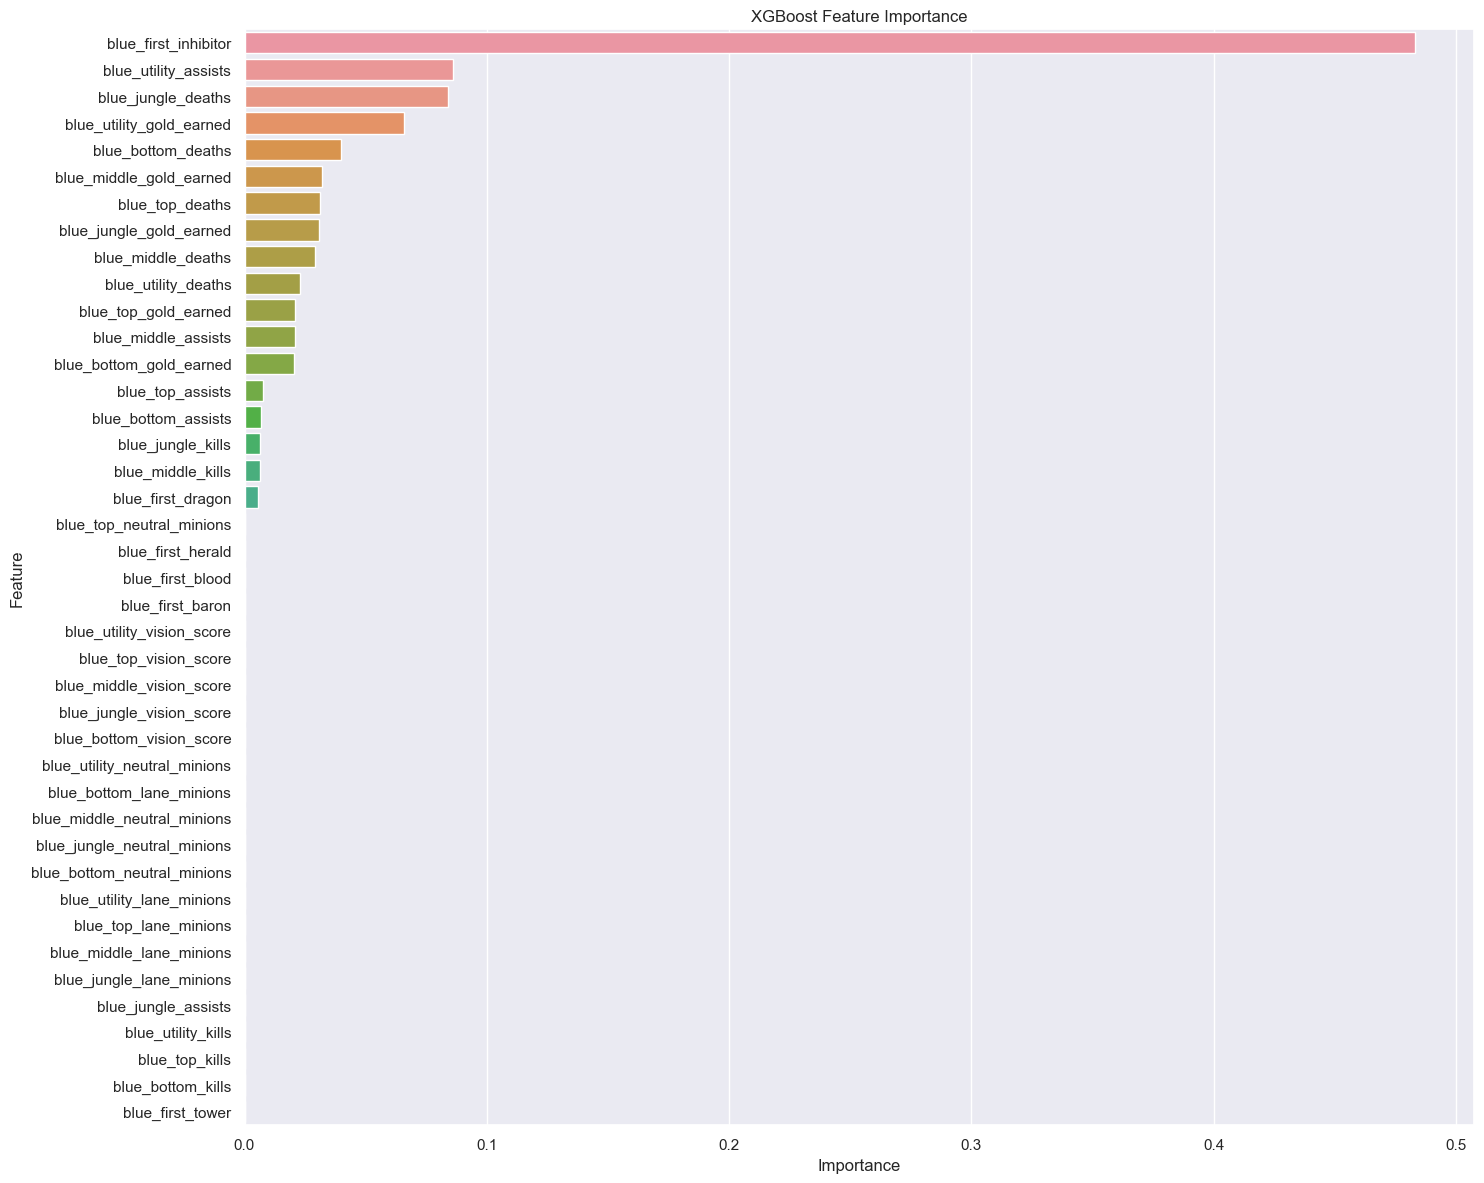

In [28]:
# Plot config
sns.set(style="darkgrid", context="talk", palette="Dark2")
sns.set(rc={"figure.figsize": (15,9)})
fig, ax = plt.subplots(figsize=(15,12))

# Get feature importance
feature_importance = tuned_xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': match_features, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Visualize feature importance
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, orient='h')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

### First Inhibitor
We can observe that `first_inhibitor` has the most significant impact on our XGBoost model. As I previously mentioned, the snowball effect is even bigger in a higher tier ranked match, where everyone is a great League of Legend player. Destroying the first inhibitor will summon the super minions, forcing the enemy team to defend their base, who would then lose important game objectives such as dragons and barons. As a result, it becomes exceptionally difficult for the opposing team to win at that point, especially if you are against good players who rarely make mistakes.

### Assists
Number of assists in each position is also an important feature, where assist from the support (utility) role is the most influential in predicting the game outcome. Support players usually help other players (mainly the ADCs) to grow, and high number of assists means that they contributed to other lanes through kills, which would then give extra 300 golds to the other players that could win the game. In addition, assists could generally imply that the team won a big fight or they are more coordinated, which would lead to victory.

### Deaths
Having a death is same as giving a kill to the opponent. In a high tier ranked game, not dying is probably more important than getting a kill. If the player is making aggressive moves for more kills, the player's probability of dying is higher, giving an advantage to the opposing team. In a sense, a kill is a bonus 300 golds while dying is a loss. Therefore, having a low number of death means that the player rarely gives an advantage to the enemy team. This is especially important for the jungler, which is a key position to take the objectives and give pressure by "ganking" the lanes. High number of jungler's death will lead to reduced map dominance, giving advantage to the enemy laners and losing objectives to win the game.

### Gold Earned
Earning more gold implies better items, more kills, and more assists to win the game. Surprisingly, the support player's gold had more importance than the rest of the positions. As we analyzed in the `assists` feature, this can explained by how support players in top-tier ranks usually contribute to other lanes by roaming. Consequently, more earned gold also implies map dominance of the winning team.

***
## Conclusion
In this project, we gathered ranked game match data using the Riot API and preprocessed it to train our model for win/loss prediction. Our findings show that destroying the first inhibitor is the most important predictor for high-tiered ranked games. Unfortunately, Riot API does not provide live match data due to fairness of the game, and the spectator mode API request returns a different data. Consequently, our current predictive capabilities do not extend to real-time match outcomes, but however, we might be able to apply our prediction model on LoL eSports world championship game, where the applicable features are displayed on live.